In [2]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from cpgan import init_yaml
from cpgan.eval.models_lib.ex6 import generator
import pandas as pd
from cpgan.ooppnm import img_process
from cpgan.ooppnm import pnm_sim
import random
import porespy as ps
from cpgan.eval.util import z_perturb
import pickle
from cpgan.ooppnm import pnm_sim_boundary
from cpgan.ooppnm import pnm_sim_old

import sys
import io

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = io.StringIO()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

f_yaml = init_yaml.yaml_f
img_prc = img_process.Image_process()

def load_gan(ex,epoch):
    f_yaml = init_yaml.yaml_f
    gen_path = os.path.join(f_yaml['model'],"ex{}/cganex{}-{}.pth".format(ex,ex,epoch))
    gen = generator.Generator(z_dim=200)
    gen.load_state_dict(torch.load(gen_path,map_location=torch.device('cpu')))
    gen.eval()
    return gen

def z_to_img(z,gen):
    img = img_prc.clean_img_filt( gen(z) )[0]
    return img

#### Control porosity generation

In [2]:
ex = 6
epoch_gan = 15

# load model and features
gen = load_gan(ex,epoch_gan)
phys_func = img_prc.phi

target_phi = 0.2

opt = z_perturb.Z_perturb(gen,phys_func,target_phi)
z,_,_,epoch = opt.optimize(100,0.01,eta=0.5)
print("epoch: ",epoch)
img = z_to_img(z,gen) > 0.5
print("phi: ",img_prc.phi(img), "target phi: ",target_phi)


Epoch 0, error: -0.001204681396484386
epoch:  0
phi:  0.19410228729248047 target phi:  0.2


In [3]:
# generate porosity
data_pnm = pnm_sim_old.Pnm_sim(im=img)
data_pnm.network_extract()
psd = data_pnm['pore.diameter']
tsd = data_pnm['throat.diameter']

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  259
Peaks after trimming saddle points:  150
Peaks after trimming nearby peaks:  150
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 244/244 [00:00<00:00, 321.52it/s]


#### Control absolute perm generation

In [4]:
def kabs_sim(img):
    with SuppressPrint():   
        data_pnm = pnm_sim_old.Pnm_sim(im=img)
        data_pnm.network_extract()
        if data_pnm.error == 1:
            print('Error in network extraction')
            return None
        data_pnm.init_physics()
        data_pnm.get_absolute_perm()
        kabs = data_pnm.data_tmp['kabs']
        data_pnm.close_ws()
    return kabs



target_k = 100
ex = 6
epoch_gan = 15

# load model and features
gen = load_gan(ex,epoch_gan)
opt = z_perturb.Z_perturb(gen,kabs_sim,target_k)
z,_,_,epoch = opt.optimize(100,15,eta=0.5)
print("epoch: ",epoch)
img = z_to_img(z,gen) > 0.5
print("k: ",kabs_sim(img), "target k: ",target_k)



(128, 128, 128)
Epoch 0, error: 122.5587474221212
(128, 128, 128)
Epoch 1, error: 131.61813718419165
(128, 128, 128)
Epoch 2, error: 87.7998791595092
(128, 128, 128)
Epoch 3, error: -20.023342100784106
(128, 128, 128)
Epoch 4, error: -65.36291104408924
(128, 128, 128)
Epoch 5, error: 3.7214412787041056
epoch:  5
k:  95.85749087862727 target k:  100


#### Control mean pore size generation

In [3]:
def psd_sim(img):
    with SuppressPrint():   
        data_pnm = pnm_sim_old.Pnm_sim(im=img)
        data_pnm.network_extract()
        if data_pnm.error == 1:
            print('Error in network extraction')
            return None
            
    psd = data_pnm.data_tmp['pore.diameter']
    tsd = data_pnm.data_tmp['throat.diameter']
    return psd


target_psd = 1.1e-05
ex = 6
epoch_gan = 15

# load model and features
gen = load_gan(ex,epoch_gan)
opt = z_perturb.Z_perturb(gen,psd_sim,target_psd)
z,_,_,epoch = opt.optimize(100,5e-07,eta=0.5)
print("epoch: ",epoch)
img = z_to_img(z,gen) > 0.5
print("psd: ",psd_sim(img), "target psd: ",target_psd)


(128, 128, 128)
Epoch 0, error: -1.610405186456056e-07
epoch:  0
psd:  1.162330446409632e-05 target psd:  1.1e-05


#### Control mean Throat size generation

In [5]:
def tsd_sim(img):
    with SuppressPrint():   
        data_pnm = pnm_sim_old.Pnm_sim(im=img)
        data_pnm.network_extract()
        if data_pnm.error == 1:
            print('Error in network extraction')
            return None
            
    psd = data_pnm.data_tmp['pore.diameter']
    tsd = data_pnm.data_tmp['throat.diameter']
    return tsd


target_tsd = 1.4e-05
ex = 6
epoch_gan = 15

# load model and features
gen = load_gan(ex,epoch_gan)
opt = z_perturb.Z_perturb(gen,psd_sim,target_psd)
z,_,_,epoch = opt.optimize(100,5e-07,eta=0.5)
print("epoch: ",epoch)
img = z_to_img(z,gen) > 0.5
print("tsd: ",tsd_sim(img), "target tsd: ",target_tsd)

(128, 128, 128)
Epoch 0, error: -6.406582442392387e-07
(128, 128, 128)
Epoch 1, error: -1.1040572113322936e-06
(128, 128, 128)
Epoch 2, error: -7.441005927736806e-07
(128, 128, 128)
Epoch 3, error: -1.224971318626234e-06
(128, 128, 128)
Epoch 4, error: -4.232838503464131e-07
epoch:  4
tsd:  1.667673208774207e-05 target tsd:  1.4e-05


#### Evaluate condtion generation


total minutes for 100 samples conditioning: 22.734983730316163
Average time for conditioning: 0.22734983730316163 minutes
total simulation epochs: 15.568627450980392
RMSE: 0.005441627778583189


(0.15, 0.32)

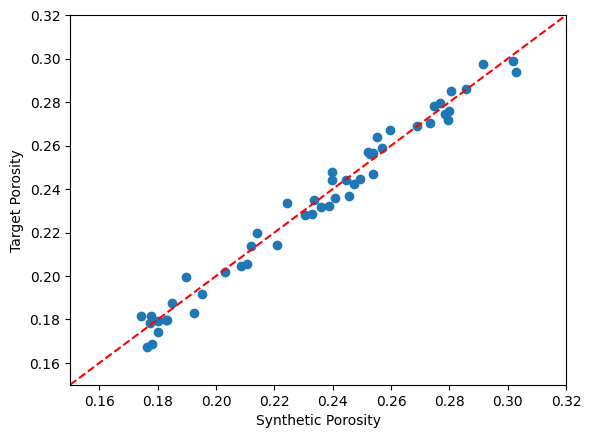

In [16]:
# read pickle file 

with open('cond_result/porosity_dict.pkl', 'rb') as f:
    data = pickle.load(f)
print('total minutes for 100 samples conditioning: {}'.format(data['time']/60))
print('Average time for conditioning: {} minutes'.format(data['time']/60/100)) 
print('total simulation epochs: {}'.format(sum(data['epoch_list'])/len(data['epoch_list'])))

# calculate root mean squared error between target list and generated porosity list
rmse = np.sqrt(np.mean((np.array(data['target_list'])-np.array(data['generate_list']))**2))
print('RMSE: {}'.format(rmse))

# scatter plot target porosity vs conditional porosity
plt.figure()
plt.scatter(data['generate_list'],data['target_list'])
plt.xlabel('Synthetic Porosity')
plt.ylabel('Target Porosity')
# generate a line between 0.15 and 0.32
x = np.linspace(0.15,0.32,100)
y = x
plt.plot(x,y,'r--')
plt.xlim([0.15,0.32])
plt.ylim([0.15,0.32])

total minutes for 100 samples conditioning: 69.67210842768351
total simulation epochs: 14.88888888888889
Average time for conditioning: 0.6967210842768351 minutes
RMSE: 9.89273509942075


(80.0, 320.0)

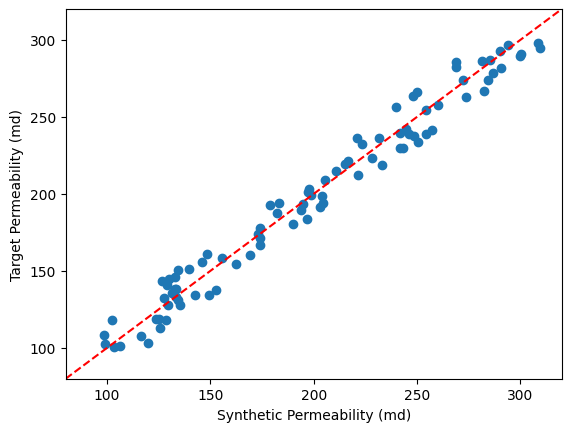

In [17]:
with open('cond_result/kabs_dict.pkl', 'rb') as f:
    data = pickle.load(f)
print('total minutes for 100 samples conditioning: {}'.format(data['time']/60))
print('total simulation epochs: {}'.format(sum(data['epoch_list'])/len(data['epoch_list'])))
print('Average time for conditioning: {} minutes'.format(data['time']/60/100)) 

# calculate root mean squared error between target list and generated porosity list
rmse = np.sqrt(np.mean((np.array(data['target_list'])-np.array(data['generate_list']))**2))
print('RMSE: {}'.format(rmse))

# scatter plot target porosity vs conditional porosity
plt.figure()
plt.scatter(data['generate_list'],data['target_list'])
plt.xlabel('Synthetic Permeability (md)')
plt.ylabel('Target Permeability (md)')
# generate a line between 0.15 and 0.32
x = np.linspace(80,320,100)
y = x
plt.plot(x,y,'r--')
plt.xlim([80,320])
plt.ylim([80,320])

total minutes for 100 samples conditioning: 169.3264458735784
total simulation epochs: 12.176470588235293
Average time for conditioning: 1.693264458735784 minutes
RMSE: 5.9033371518655855e-08


(9.3e-06, 1.15e-05)

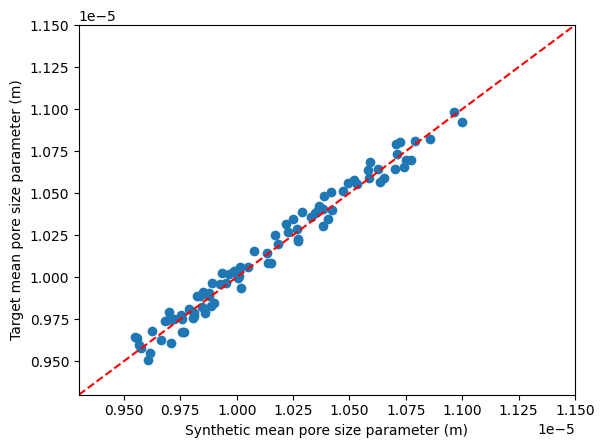

In [18]:
with open('cond_result/psd_dict.pkl', 'rb') as f:
    data = pickle.load(f)
print('total minutes for 100 samples conditioning: {}'.format(data['time']/60))
print('total simulation epochs: {}'.format(sum(data['epoch_list'])/len(data['epoch_list'])))
print('Average time for conditioning: {} minutes'.format(data['time']/60/100)) 

# calculate root mean squared error between target list and generated porosity list
rmse = np.sqrt(np.mean((np.array(data['target_list'])-np.array(data['generate_list']))**2))
print('RMSE: {}'.format(rmse))

# scatter plot target porosity vs conditional porosity
plt.figure()
plt.scatter(data['generate_list'],data['target_list'])
plt.xlabel('Synthetic mean pore size parameter (m)')
plt.ylabel('Target mean pore size parameter (m)')
# generate a line between 0.15 and 0.32
x = np.linspace(0.93e-05,1.15e-05,100)
y = x
plt.plot(x,y,'r--')
plt.xlim([0.93e-05,1.15e-05])
plt.ylim([0.93e-05,1.15e-05])

total minutes for 100 samples conditioning: 525.1628527522087
total simulation epochs: 22.515625
Average time for conditioning: 5.251628527522087 minutes
RMSE: 2.855159185903078e-08


(3.4e-06, 4.3e-06)

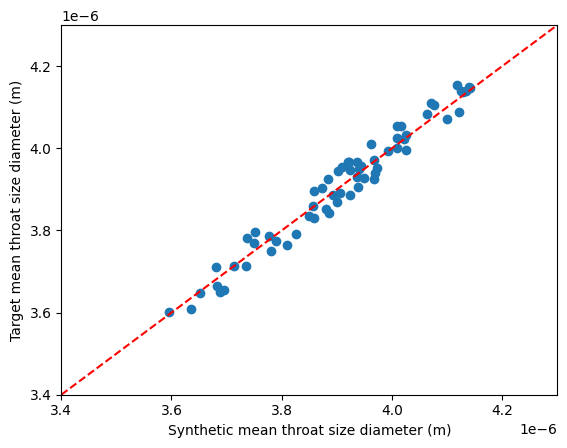

In [19]:
with open('cond_result/tsd_dict.pkl', 'rb') as f:
    data = pickle.load(f)
print('total minutes for 100 samples conditioning: {}'.format(data['time']/60))
print('total simulation epochs: {}'.format(sum(data['epoch_list'])/len(data['epoch_list'])))
print('Average time for conditioning: {} minutes'.format(data['time']/60/100)) 

# calculate root mean squared error between target list and generated porosity list
rmse = np.sqrt(np.mean((np.array(data['target_list'])-np.array(data['generate_list']))**2))
print('RMSE: {}'.format(rmse))

# scatter plot target porosity vs conditional porosity
plt.figure()
plt.scatter(data['generate_list'],data['target_list'])
plt.xlabel('Synthetic mean throat size diameter (m)')
plt.ylabel('Target mean throat size diameter (m)')
# generate a line between 0.15 and 0.32
x = np.linspace(3.4e-06,4.3e-06,100)
y = x
plt.plot(x,y,'r--')
plt.xlim([3.4e-06,4.3e-06])
plt.ylim([3.4e-06,4.3e-06])